# ERA5 at glacier locations

Code and data used to generate data for our [Glacier Explorer](http://edu.oggm.org/en/latest/explorer.html)

In [1]:
# Data wrangling libs
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
# Just for download and fancy bar
from oggm import utils
import progressbar
# Plots
import matplotlib.pyplot as plt
import seaborn as sns

### Glacier location and area

We download data from the [Randolph Glacier Inventory (RGI 6.0)](https://www.glims.org/RGI/), pre-processed in tabular form:

In [2]:
# RGI statistics as csv
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~fmaussion/misc/rgi62_allglaciers.csv')
odf = pd.read_csv(frgi, index_col=0,
                  converters={'Name':str, 'GLIMSId': str, 'BgnDate':str, 'EndDate':str, 
                              'O1Region': str, 'O2Region':str, 
                              'IsTidewater':bool, 'IsNominal':bool})

No known hash for cluster.klima.uni-bremen.de/~fmaussion/misc/rgi62_allglaciers.csv


Some data wrangling to locate the ERA5 grid points where we have glaciers:

In [3]:
f_era = utils.file_downloader('https://cluster.klima.uni-bremen.de/~fmaussion/climate/era5/monthly/v1.0/era5_monthly_t2m_1979-2018.nc')
ds = xr.open_dataset(f_era).chunk(chunks={'time':12})
nx, ny = ds.dims['longitude'], ds.dims['latitude']
# Nearest neighbor lookup
cenlon_for_bins = np.where(odf['CenLon'] < -0.125, odf['CenLon']+360, odf['CenLon'])
lon_bins = np.linspace(-0.125, 359.75+0.125, nx)
lat_bins = np.linspace(90+0.125, -90-0.125, ny)
odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of ERA5 gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

No known hash for cluster.klima.uni-bremen.de/~fmaussion/climate/era5/monthly/v1.0/era5_monthly_t2m_1979-2018.nc


Total number of glaciers: 216502 and number of ERA5 gridpoints with glaciers in them: 11323


## Now the fun part 

In [2]:
fds = xr.open_dataset('era5_annual_glacierloc_1979-2018.nc')

In [3]:
fds.info()

xarray.Dataset {
dimensions:
	time = 40 ;
	zone_id = 11323 ;

variables:
	float32 t2m(time, zone_id) ;
		t2m:units = K ;
		t2m:long_name = 2m air temperature ;
	float64 pcp(time, zone_id) ;
		pcp:units = mm yr-1 ;
		pcp:long_name = Total precipitation ;
	float32 surface_elev(zone_id) ;
		surface_elev:units = m ;
		surface_elev:long_name = ERA5 surface elevation ;
	float32 landmask(zone_id) ;
		landmask:units = (0 - 1) ;
		landmask:long_name = Land-sea mask ;
		landmask:standard_name = land_binary_mask ;
	float64 glacier_area(zone_id) ;
		glacier_area:units = km2 ;
		glacier_area:long_name = Total glacier area in grid-point ;
	float64 trend(zone_id) ;
		trend:units = K decade-1 ;
		trend:long_name = 40yr 2mtemperature trend ;
	float64 trend_std_err(zone_id) ;
		trend_std_err:units = K decade-1 ;
		trend_std_err:long_name = 40yr 2mtemperature trend standard error ;
	float64 trend_p_values(zone_id) ;
		trend_p_values:units = - ;
		trend_p_values:long_name = 40yr 2mtemperature trend p-valu

In [5]:
fdsm = fds.mean(dim='time')

In [6]:
fdsm

<xarray.Dataset>
Dimensions:         (zone_id: 11323)
Coordinates:
    latitude        (zone_id) float32 ...
  * zone_id         (zone_id) object '852_105' '853_106' ... '151_547'
    longitude       (zone_id) float32 ...
Data variables:
    t2m             (zone_id) float32 266.63727 266.06006 ... 278.84894
    pcp             (zone_id) float64 763.1 801.5 823.3 ... 667.1 1.206e+03
    surface_elev    (zone_id) float32 1520.6927 1472.6215 ... 25.721743
    landmask        (zone_id) float32 0.99342316 0.995941 ... 0.06749272
    glacier_area    (zone_id) float64 28.53 561.1 48.82 ... 5.547 0.011 0.528
    trend           (zone_id) float64 0.1444 0.1596 0.1339 ... -0.09588 0.006869
    trend_std_err   (zone_id) float64 0.1316 0.1297 0.1306 ... 0.113 0.042
    trend_p_values  (zone_id) float64 0.2793 0.2262 0.3115 ... 0.4015 0.871

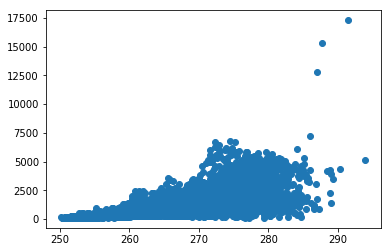

In [7]:
plt.scatter(fdsm.t2m, fdsm.pcp);

In [8]:
for zid in progressbar.progressbar(mdf.index):
    sel_in = fdsm.sel(zone_id=zid)
    sel_out = odf.loc[odf.unique_id == zid]
    
    odf.loc[odf.unique_id == zid, 'era5_avg_temp_at_zmed'] = (sel_in.surface_elev.data- sel_out.Zmed) * 0.0065 + sel_in.t2m.data - 273.15
    odf.loc[odf.unique_id == zid, 'era5_avg_pcp'] =  sel_in.pcp.data
    odf.loc[odf.unique_id == zid, 'era5_elev'] = sel_in.surface_elev.data
    odf.loc[odf.unique_id == zid, 'era5_landmask'] =  sel_in.landmask.data
    odf.loc[odf.unique_id == zid, 'era5_trend'] =  sel_in.trend.data
    odf.loc[odf.unique_id == zid, 'era5_trend_std_err'] =  sel_in.trend_std_err.data
    odf.loc[odf.unique_id == zid, 'era5_trend_p_values'] =  sel_in.trend_p_values.data

100% (11323 of 11323) |##################| Elapsed Time: 0:15:57 Time:  0:15:57


In [10]:
odf.to_hdf('rgi62_era5_df.h5', key='df', mode='w')

/home/mowglie/.pyvirtualenvs/py3/lib/python3.5/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['GLIMSId', 'BgnDate', 'EndDate', 'O1Region', 'O2Region', 'Name', 'check_geom', 'GlacierType', 'TerminusType', 'GlacierStatus', 'unique_id']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [11]:
odf.to_csv('rgi62_era5_df.csv')

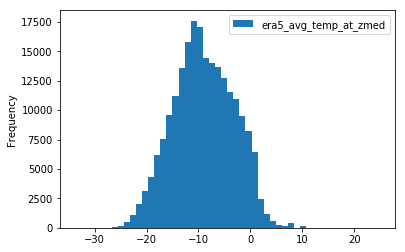

In [13]:
odf[['era5_avg_temp_at_zmed']].plot(kind='hist', bins=50)

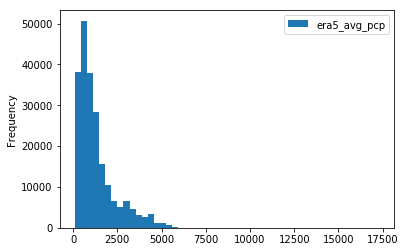

In [14]:
odf[['era5_avg_pcp']].plot(kind='hist', bins=50)

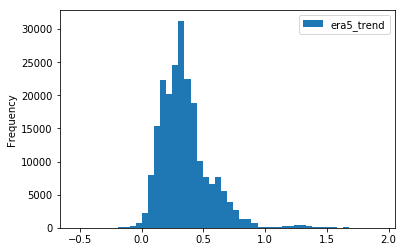

In [15]:
odf[['era5_trend']].plot(kind='hist', bins=50)